In [10]:
#!pip install pyserial
#!pip install ipympl
#!pip install ipywidgets

In [2]:
# Enable interactive plotting in Jupyter Notebook
#%matplotlib notebook
%matplotlib widget

import serial
import time
import sys
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from utils import convert as c

In [3]:
def poll_usb_port(port, baudrate, row_bytes, cb):
    try:
        ser = serial.Serial(port, baudrate, timeout=1)
        print(f"Opened port {port} with baud rate {baudrate}")

        # stream data
        row_count = 0
        while True:
            if ser.in_waiting > 0:
                # Read data from the serial port 
                row = ser.read(row_bytes)
                #convert row
                converted_row = c.unpacking_v2_format_hig(row)
                #print(f"coverted row: {converted_row}")
                cb(converted_row, row_count)
                row_count = row_count + 1
            else:
                # No data received, sleep for a short while
                time.sleep(0.1)
                
    except serial.SerialException as e:
        print(f"Error: {e}")
    except KeyboardInterrupt:
        print("Exiting program")
    finally:
        if ser.is_open:
            ser.close()
            print(f"Closed port {port}")

def poll_for_data_files(mount_point, output_dir, data_file_name):
    try:
        # poll the mount_point until it is ready
        while not os.path.ismount(mount_point):
            print(f"waiting for device to mount")
            time.sleep(0.5)
        
        #files = os.listdir(mount_point)
        data_files = glob.glob(os.path.join(mount_point, '*.HIG'))
        
        print(f"Files in {mount_point}:")

        columns = ['x', 'y', 'z', 'mag']

        for file in data_files:
            print(f"converting data file {file}")
            converted_data = c.get_results_v2_format(file)
            # Create the DataFrame
            df = pd.DataFrame(converted_data[0], columns=columns)
            df.to_csv(f"{output_dir}{data_file_name}.csv", index=False)

    except Exception as e:
        print(f"Error: {e}")        

In [35]:
# read data file directly from the sensor on plugin and convert to csv
output_dir = "data/"
data_file_name = "patient_name_test1"
poll_for_data_files('/media/mike/641A-F4BD', output_dir, data_file_name)

Files in /media/mike/641A-F4BD:
converting data file /media/mike/641A-F4BD/SM010731211403.HIG
getting results for /media/mike/641A-F4BD/SM010731211403.HIG
completed conversion


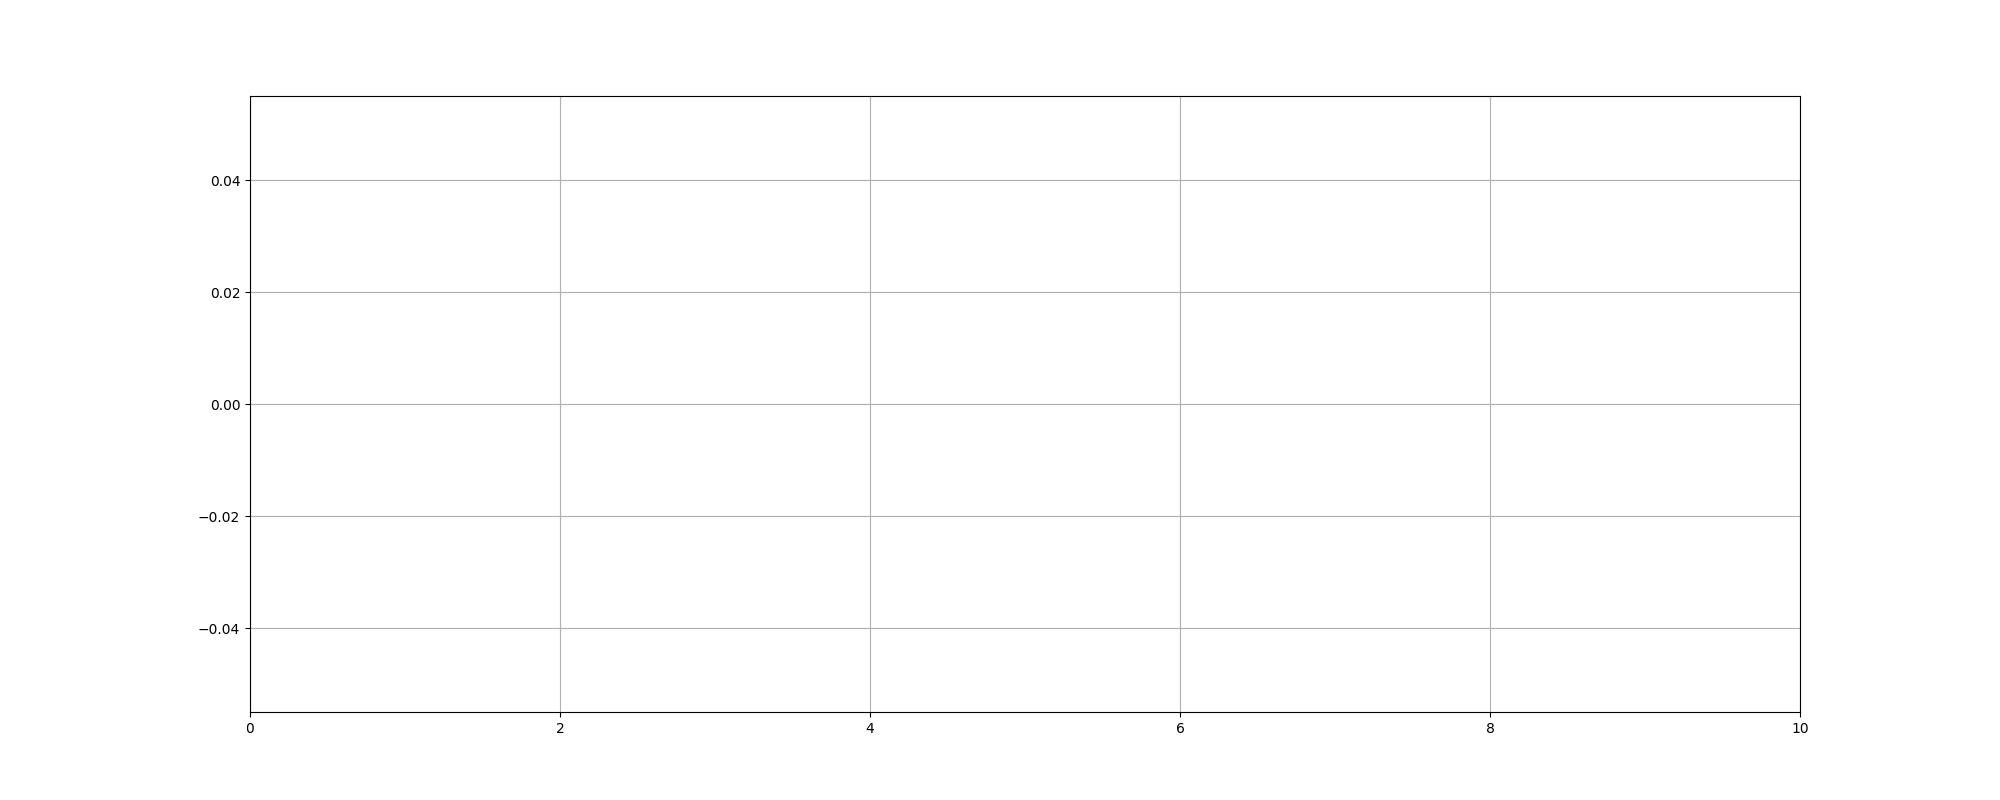

Opened port /dev/ttyACM0 with baud rate 115200
Exiting program
Closed port /dev/ttyACM0
thread


In [15]:

x_data = []
y_data = []
z_data = []
time_index = []

def converted_data_callback(data, t_index):
    x_data.append(data[0])
    y_data.append(data[1])
    z_data.append(data[2])
    time_index.append(t_index)

# Set up the figure and axis
fig, ax = plt.subplots(1,1, figsize=(20, 8))
line1, = ax.plot([], [], lw=2, label='Line 1')
line2, = ax.plot([], [], lw=2, label='Line 2')
line3, = ax.plot([], [], lw=2, label='Line 3')
ax.set_xlim(0, 10)
#ax.set_ylim(-1.5, 1.5)
ax.grid()

# Function to initialize the plot
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

# Function to update the plot
def update(frame):
    print("updating")
    line1.set_data(time_index, x_data)
    line2.set_data(time_index, y_data)
    line3.set_data(time_index, z_data)
    return line1, line2, line3



# Create an instance of the animation
ani = animation.FuncAnimation(fig, update, init_func=init, blit=True, interval=100, cache_frame_data=False ) # Disable frame data caching)

plt.show()

# start on thread
import threading
# Start the data simulation in a separate thread
data_thread = threading.Thread(target=poll_usb_port('/dev/ttyACM0', 115200, 11, converted_data_callback), daemon=True)
data_thread.start()
print("thread")
